In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from movie_sentiment.processing.arcs import get_all_polynomials, get_all_reshaped_arcs, get_all_arcs, get_all_dyn_arcs

### Loading data

In [2]:
#arcs = get_all_reshaped_arcs()
arcs = get_all_reshaped_arcs(dyn_avg=True)

Loading data from pickle file


In [3]:
arcs

,movie_name,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
0,Fernando Arrabal lit Sa corolle noire ditions ...,-0.077136,-0.096570,-0.053010,-0.051870,-0.051044,0.045461,0.093039,0.073123,-0.015400,...,0.219484,0.173177,0.107540,0.023627,0.055310,0.055935,0.068851,0.129093,0.184042,0.330231
1,It s Kind of a Funny Story,0.278891,0.348840,0.395423,0.377259,0.382969,0.343162,0.290915,0.251488,0.228091,...,0.189855,0.176844,0.210599,0.244438,0.240946,0.310362,0.335831,0.437604,0.504113,0.365996
2,Neither Seen Nor Recognized,0.039235,0.059514,0.022324,0.038502,0.060972,0.098033,0.148244,0.126875,0.101451,...,-0.034397,-0.075627,-0.093596,-0.125936,-0.112881,-0.070995,-0.032540,0.037251,0.135784,0.000595
3,The Secret Life of Pets,0.343824,0.289984,0.322738,0.358002,0.279514,0.228332,0.197123,0.151848,0.089206,...,0.047021,0.058927,0.110069,0.085729,0.175066,0.231830,0.234078,0.249028,0.105298,0.400818
4,Richard Jewell,-0.261737,-0.183591,-0.216643,-0.179409,-0.129997,-0.029868,0.027518,-0.007783,0.004369,...,0.019662,-0.054056,-0.069415,-0.079938,-0.069520,-0.062225,-0.054177,0.007203,0.022057,0.087764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2767,Lord of Illusions,-0.273516,-0.360499,-0.296610,-0.194838,-0.200526,-0.215920,-0.143052,-0.110134,-0.068536,...,-0.074329,-0.136816,-0.226362,-0.218744,-0.216455,-0.276052,-0.243529,-0.321754,-0.321003,-0.112515
2768,First Reformed,0.303384,0.314298,0.281383,0.223623,0.176002,0.163877,0.193621,0.195732,0.204784,...,0.112673,0.120566,0.054192,0.048203,-0.000184,0.008317,0.004223,0.082854,0.227281,0.072542
2769,Then She Was Gone,0.009273,0.064375,0.130200,0.169529,0.153080,0.187181,0.189482,0.222806,0.185147,...,0.155723,0.146056,0.156597,0.144282,0.129060,0.108117,0.129719,0.142421,0.131764,0.146085
2770,Kill Bill Vol 1,-0.521851,-0.455342,-0.426858,-0.434941,-0.420221,-0.409471,-0.262395,-0.224574,-0.192153,...,-0.353372,-0.332127,-0.222312,-0.175093,-0.245336,-0.150000,-0.153794,-0.083801,-0.105975,-0.305683


In [4]:
X = arcs.drop(columns='movie_name')
X

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.077136,-0.096570,-0.053010,-0.051870,-0.051044,0.045461,0.093039,0.073123,-0.015400,0.004344,...,0.219484,0.173177,0.107540,0.023627,0.055310,0.055935,0.068851,0.129093,0.184042,0.330231
1,0.278891,0.348840,0.395423,0.377259,0.382969,0.343162,0.290915,0.251488,0.228091,0.259630,...,0.189855,0.176844,0.210599,0.244438,0.240946,0.310362,0.335831,0.437604,0.504113,0.365996
2,0.039235,0.059514,0.022324,0.038502,0.060972,0.098033,0.148244,0.126875,0.101451,0.064315,...,-0.034397,-0.075627,-0.093596,-0.125936,-0.112881,-0.070995,-0.032540,0.037251,0.135784,0.000595
3,0.343824,0.289984,0.322738,0.358002,0.279514,0.228332,0.197123,0.151848,0.089206,0.035244,...,0.047021,0.058927,0.110069,0.085729,0.175066,0.231830,0.234078,0.249028,0.105298,0.400818
4,-0.261737,-0.183591,-0.216643,-0.179409,-0.129997,-0.029868,0.027518,-0.007783,0.004369,-0.081983,...,0.019662,-0.054056,-0.069415,-0.079938,-0.069520,-0.062225,-0.054177,0.007203,0.022057,0.087764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2767,-0.273516,-0.360499,-0.296610,-0.194838,-0.200526,-0.215920,-0.143052,-0.110134,-0.068536,-0.025539,...,-0.074329,-0.136816,-0.226362,-0.218744,-0.216455,-0.276052,-0.243529,-0.321754,-0.321003,-0.112515
2768,0.303384,0.314298,0.281383,0.223623,0.176002,0.163877,0.193621,0.195732,0.204784,0.127112,...,0.112673,0.120566,0.054192,0.048203,-0.000184,0.008317,0.004223,0.082854,0.227281,0.072542
2769,0.009273,0.064375,0.130200,0.169529,0.153080,0.187181,0.189482,0.222806,0.185147,0.219705,...,0.155723,0.146056,0.156597,0.144282,0.129060,0.108117,0.129719,0.142421,0.131764,0.146085
2770,-0.521851,-0.455342,-0.426858,-0.434941,-0.420221,-0.409471,-0.262395,-0.224574,-0.192153,-0.267084,...,-0.353372,-0.332127,-0.222312,-0.175093,-0.245336,-0.150000,-0.153794,-0.083801,-0.105975,-0.305683


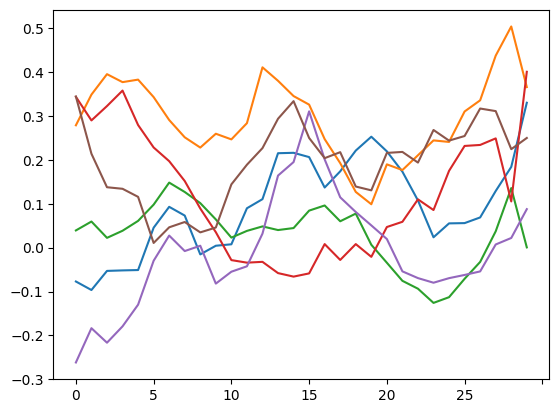

In [5]:
plots_range = range(6)

for i in plots_range:
    X.iloc[i].plot()

### Scaled data

In [18]:
s_scaler = StandardScaler()
s_scaler.fit(X.T)
scaled = s_scaler.transform(X.T)

X_scaled = pd.DataFrame(scaled.T, columns=X.columns)

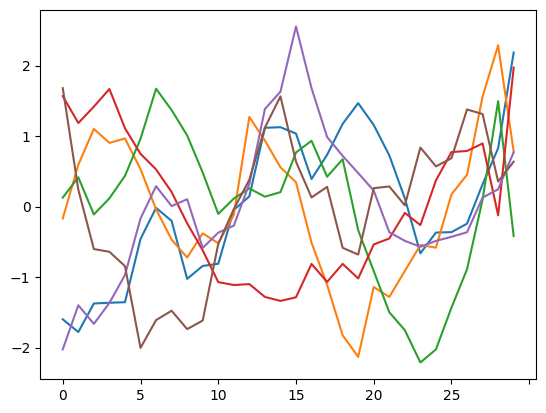

In [35]:
for i in plots_range:
    X_scaled.iloc[i].plot()

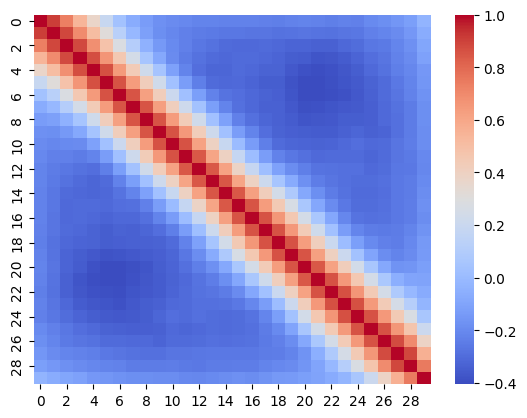

In [92]:
sns.heatmap(X_scaled.corr(), cmap='coolwarm');

### PCA

In [19]:
pca = PCA()
pca.fit(X_scaled)

PCA()

In [20]:
X_proj = pca.transform(X_scaled)
X_proj = pd.DataFrame(X_proj, columns=[f'PC{i}' for i in range(1, 31)])

In [11]:
X_proj.var() / sum(X_proj.var())

PC1     0.262924
PC2     0.197141
PC3     0.122014
PC4     0.107808
PC5     0.068476
PC6     0.059615
PC7     0.042286
PC8     0.037355
PC9     0.026326
PC10    0.016759
PC11    0.011097
PC12    0.007225
PC13    0.005539
PC14    0.004595
PC15    0.004331
PC16    0.003880
PC17    0.003565
PC18    0.003155
PC19    0.002627
PC20    0.002339
PC21    0.001985
PC22    0.001623
PC23    0.001401
PC24    0.001102
PC25    0.000996
PC26    0.000908
PC27    0.000791
PC28    0.000749
PC29    0.000708
PC30    0.000679
dtype: float64

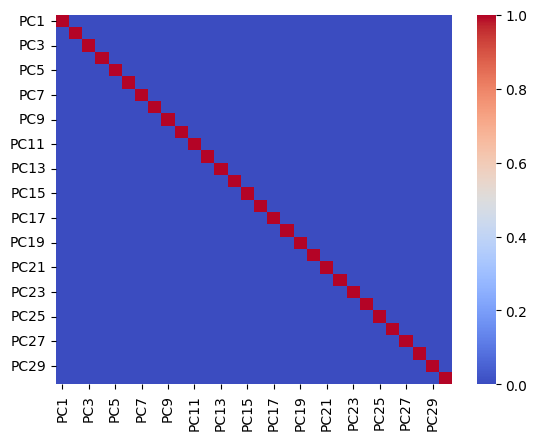

In [12]:
sns.heatmap(X_proj.corr(), cmap='coolwarm');

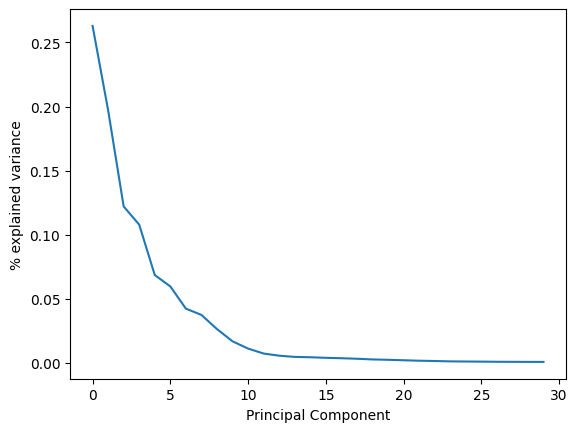

In [13]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component'); plt.ylabel('% explained variance');

### Kmeans

In [32]:
km = KMeans(n_clusters=6)
km.fit(X_proj)

/Users/sebhoch/.pyenv/versions/3.10.6/envs/movie-sentiment-analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=6)

<Axes: xlabel='PC1', ylabel='PC2'>

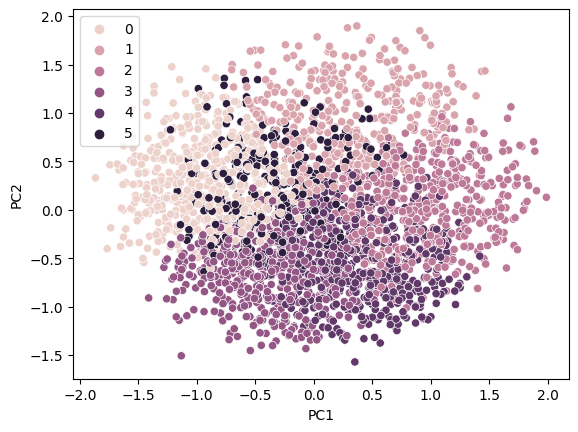

In [15]:
sns.scatterplot(x=X_proj.iloc[:,0], y=X_proj.iloc[:,1], hue=km.predict(X_proj))

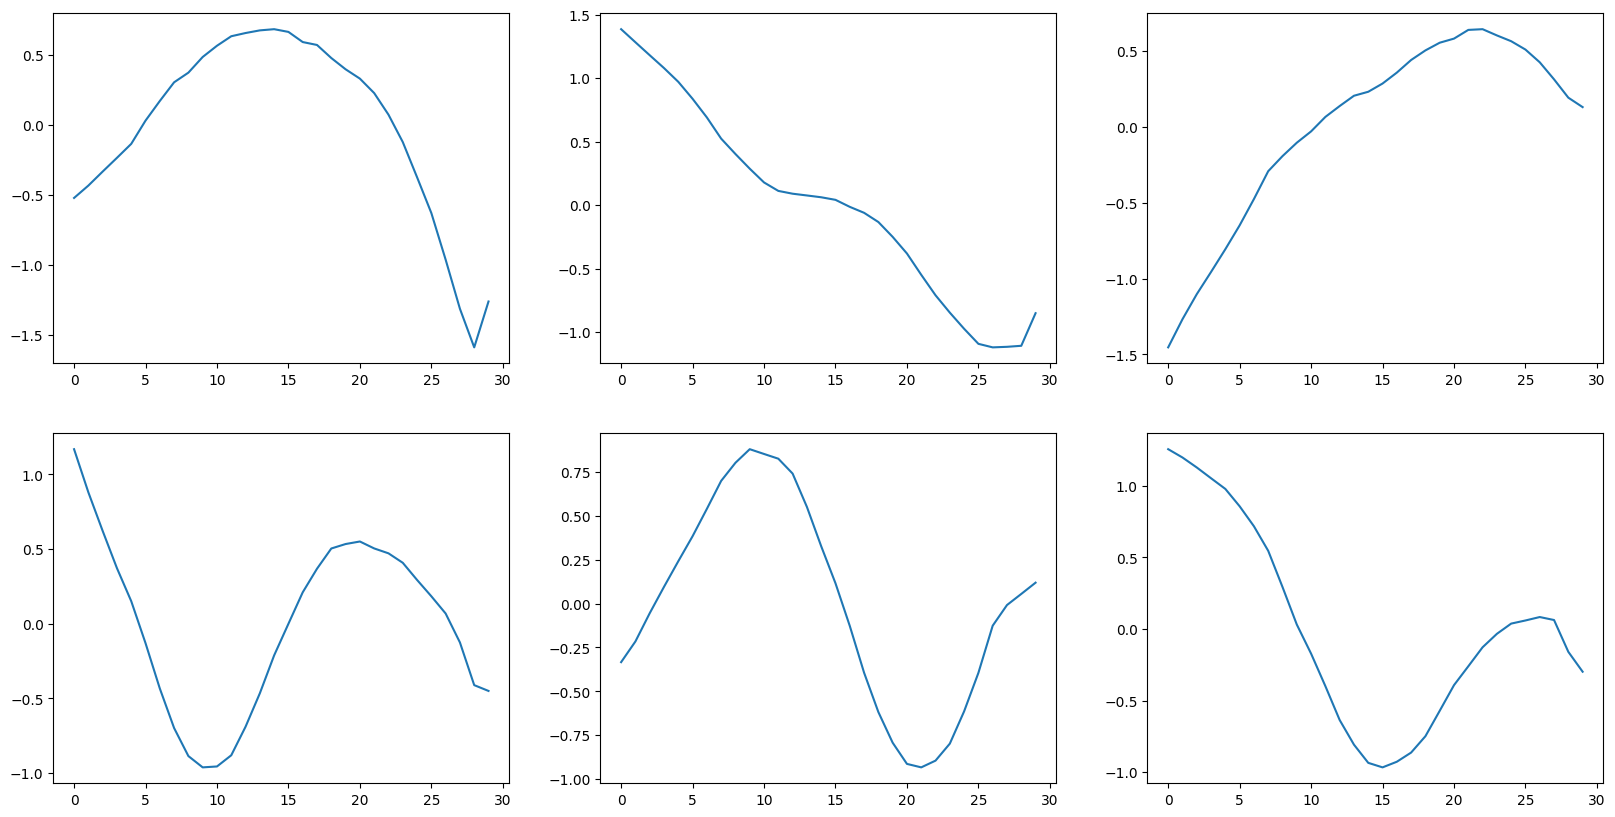

In [33]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))
for i in range (6):
    row = int(i/3)
    col = i%3
    arc = pca.inverse_transform(km.cluster_centers_[i])
    ax[row,col].plot(arc)

### Plotting the results

In [23]:
np.unique(km.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int32), array([449, 642, 404, 381, 428, 468]))

In [24]:
classified_arcs = arcs.copy()
classified_arcs['classification'] = km.labels_

for i in range(30):
    classified_arcs[i] = X_scaled[i]

In [25]:
arc_kmeans = [] 
for i in range(6):
    arc_kmeans.append(pca.inverse_transform(km.cluster_centers_[i]))

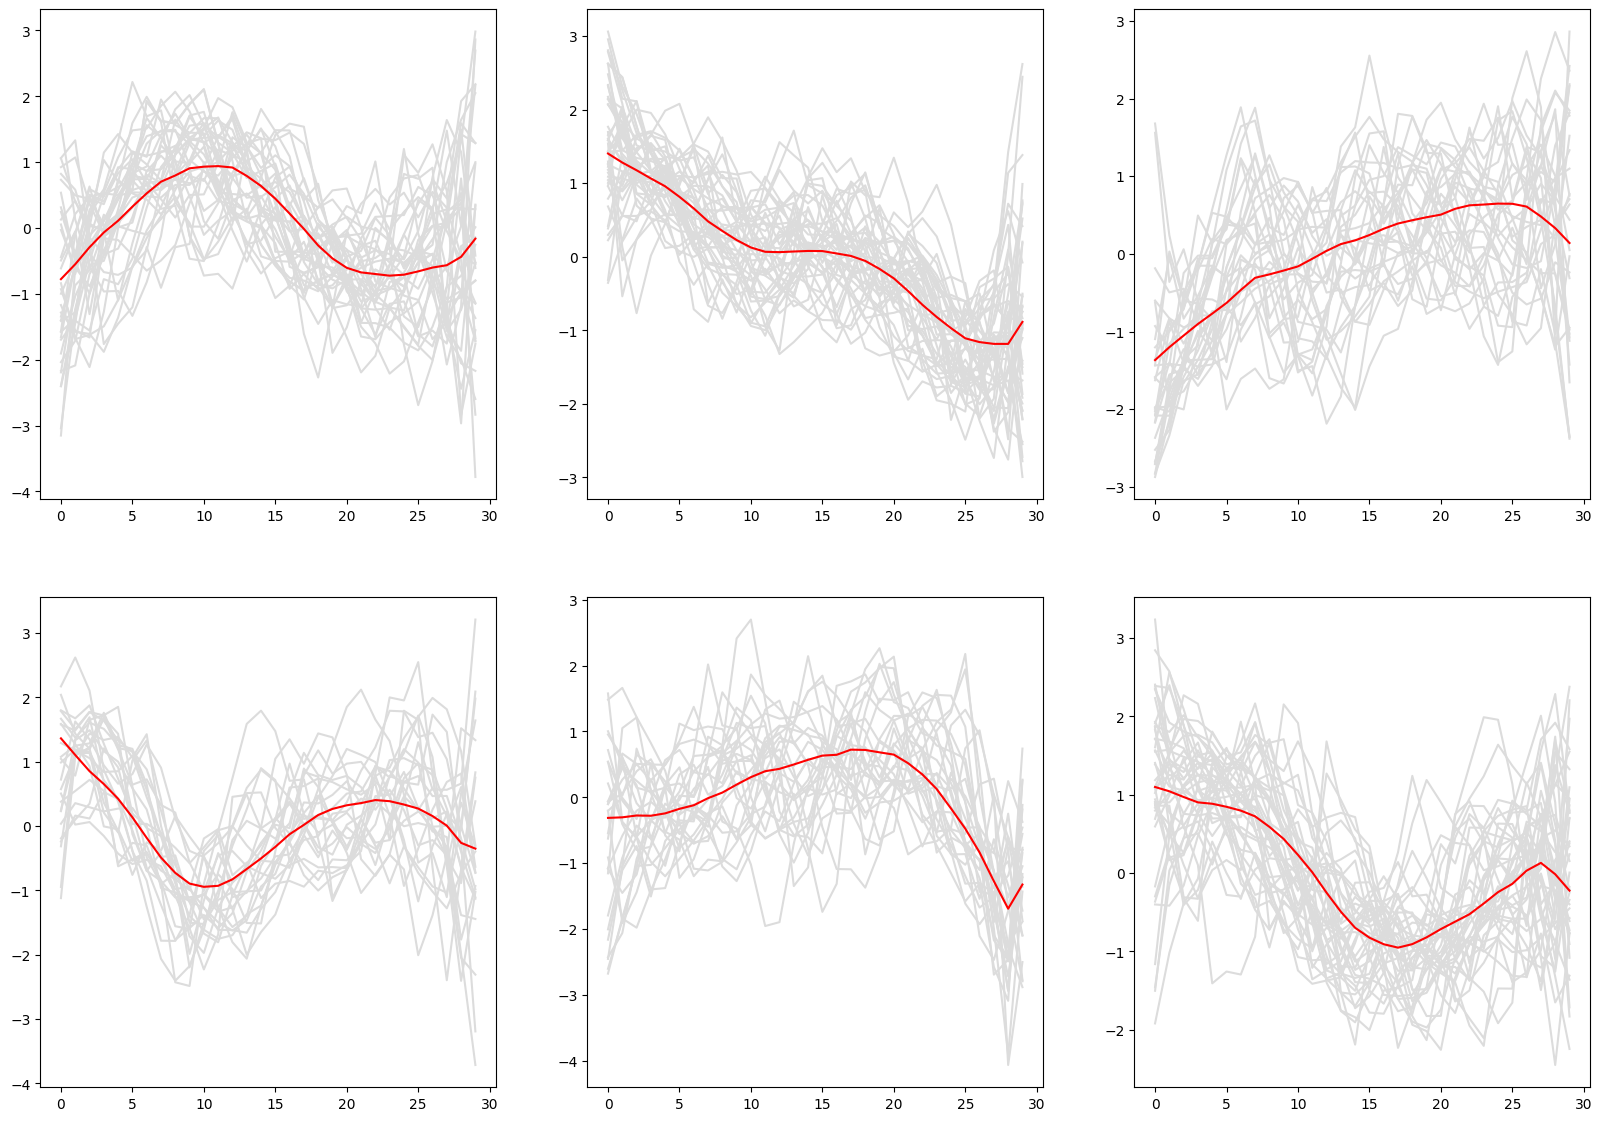

In [40]:
fig, ax = plt.subplots(2, 3, figsize=(20,14))
plot_columns = [i for i in range(30)]

for row in classified_arcs.iloc[:200,:].iterrows():
    i = row[1]['classification']
    r = int(i/3)
    c = i%3
    arc = row[1][plot_columns]
    ax[r,c].plot(arc, color='gainsboro')
    
for i in range(6):
    r = int(i/3)
    c = i%3
    ax[r,c].plot(arc_kmeans[i], color='red')